# Forward pass analysis

## visualize masks

In [1]:
// for local development
%install-location /notebooks/language2motion.gt/swift-install
%install-swiftpm-flags -c release
%install '.package(path: "/notebooks/language2motion.gt")' Datasets TranslationModels TextModels ModelSupport SummaryWriter LangMotionModels Checkpoints

Installing packages:
	.package(path: "/notebooks/language2motion.gt")
		Datasets
		TranslationModels
		TextModels
		ModelSupport
		SummaryWriter
		LangMotionModels
		Checkpoints
With SwiftPM flags: ['-c', 'release']
Working in: /tmp/tmpyw08juyp/swift-install
[1/6] Compiling STBImage stb_image_write.c
[2/6] Compiling SummaryWriter SummaryWriter.swift
[3/6] Compiling Batcher Backend.swift
[4/6] Compiling STBImage stb_image.c
[5/6] Compiling SwiftProtobuf AnyMessageStorage.swift
[6/7] Compiling ModelSupport BijectiveDictionary.swift
[7/10] Compiling TrainingLoop LossFunctions.swift
[8/10] Compiling Checkpoints CheckpointIndexReader.swift
[9/10] Compiling Datasets ArrayUtils.swift
[10/11] Compiling TextModels Attention.swift
[11/12] Compiling TranslationModels Decoder.swift
[12/13] Compiling LangMotionModels LangMotionCheckpointReader.swift
[13/14] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[14/14] Linking libjupyterInstalledPackages.so
Initializing Swift...
Installa

In [2]:
import TensorFlow
import TextModels
import TranslationModels
import Foundation
import FoundationXML
import ModelSupport
import Datasets
import SummaryWriter
import LangMotionModels
import Checkpoints
import PythonKit

In [3]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [4]:
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

## Set training params

In [5]:
let device = Device.defaultTFEager

In [6]:
let maxTextSequenceLength =  40
let maxMotionLength =  150

In [7]:
let datasetSize: DatasetSize = .full
let batchSize = 2

In [8]:
let dataURL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/")
let motionDatasetURL = dataURL.appendingPathComponent("motion_dataset_v3.10Hz.\(datasetSize.rawValue)plist")

In [10]:
/// instantiate text processor
let vocabularyURL = dataURL.appendingPathComponent("vocab.txt")
let vocabulary: Vocabulary = try! Vocabulary(fromFile: vocabularyURL)
let tokenizer: Tokenizer = BERTTokenizer(vocabulary: vocabulary, caseSensitive: false, unknownToken: "[UNK]", maxTokenLength: nil)
let textProcessor = TextProcessor(vocabulary: vocabulary, tokenizer: tokenizer)

In [12]:
/// load dataset
print("\nLoading dataset...")

var dataset = try Lang2Motion(
    motionDatasetURL: motionDatasetURL,
    batchSize: batchSize,
    minMotionLength: 20,
    maxMotionLength: 150,
    trainTestSplit: 1.0,
    device: device
) { (motionSample: MotionSample) -> LangMotionBatch in    
    let sentence = textProcessor.preprocess(sentence: motionSample.annotations[0], maxTextSequenceLength: maxTextSequenceLength)
    let (motionPart, target) = LangMotionBatch.preprocessTargetMotion(sampleID: motionSample.sampleID, motion: motionSample.motion, maxMotionLength: maxMotionLength)
    let source = LangMotionBatch.Source(sentence: sentence, motionPart: motionPart)
    let singleBatch = LangMotionBatch(source: source, target: target)
    return singleBatch
}

print("Dataset acquired.")


Loading dataset...
MotionDataset(motionSamples: 3911)
Keeping 3012 annotated motions.
Keeping 2921 longer motions, with minimum 20 frames.
Keeping 2651 shorter motions, with maximum 150 frames.
Scaling motions...
Motions scaled.
Having 5907 annotations with motions.
Dataset acquired.


In [38]:
/// instantiate model
let config = LangMotionTransformerConfig(
    vocabSize: vocabulary.count,
    nbJoints: 47,
    nbMixtures: 20,
    layerCount: 6,
    encoderDepth: 64,
    decoderDepth: 128,
    feedForwardSize: 512,
    headCount: 4,
    dropoutProbability:  0.1,
    sentenceMaxPositionalLength: 100,
    motionMaxPositionalLength: 500,
    encoderSelfAttentionTemp: 1,
    decoderSourceAttentionTemp: 1,
    decoderSelfAttentionTemp: 1
)

let runName = "run_63"
let epoch = 4

let runURL = dataURL.appendingPathComponent("runs/Lang2motion/\(runName)", isDirectory: true)
let checkpointURL = runURL.appendingPathComponent("checkpoints", isDirectory: true)
let motionsURL = runURL.appendingPathComponent("generated_motions", isDirectory: true)
try! FileManager().createDirectory(at: motionsURL, withIntermediateDirectories: true)

let model = LangMotionTransformer(checkpoint: checkpointURL, config: config, name: "model.e\(epoch)")

Loading model "model.e4" from "/notebooks/language2motion.gt/data/runs/Lang2motion/run_63/checkpoints"...


# Forward pass

In [16]:
// Loss function
let args = LossArgs(
        nb_joints: config.nbJoints,
        nb_mixtures: config.nbMixtures,
        mixture_regularizer_type: "None",  // ["cv", "l2", "None"]
        mixture_regularizer: 0.0,
        device: device
)

@differentiable(wrt: y_pred)
public func normalMixtureSurrogateLoss2(y_pred: MixtureModelPreds, y_true: LangMotionBatch.Target, args: LossArgs) -> (Tensor<Float>, Tensor<Float>) {
    // masking
    var y_pred = y_pred.squeezed()
    var y_true = y_true.squeezed()
    let ids = Tensor<Int32>(rangeFrom: 0, to: Int32(y_true.stops.shape[1]), stride: 1, on: args.device)
    let indices = ids.gathering(where: y_true.stops .!= Tensor(1, on: args.device))
    y_pred = y_pred.gathering(atIndices: indices, alongAxis: 1)
    y_true = y_true.gathering(atIndices: indices, alongAxis: 1)
    
    let loss = _normalMixtureSurrogateLoss(y_true: y_true, y_pred: y_pred, args: args)
    let mean_loss = loss.mean()
    return (mean_loss, loss)
}

## Single batch

In [17]:
let motionSample = dataset.motionSamples[0]
print("sampleID: \(motionSample.sampleID)")
print(motionSample.description)
print(motionSample.annotations)

sampleID: 1
MotionSample(timesteps: 3.77, motion: 38, annotations: 1)
["A person is walking forwards."]


In [18]:
// let sentence = textProcessor.preprocess(sentence: s, maxTextSequenceLength: maxTextSequenceLength)
let sentence = textProcessor.preprocess(sentence: motionSample.annotations[0], maxTextSequenceLength: maxTextSequenceLength)
let (motionPart, target) = LangMotionBatch.preprocessTargetMotion(sampleID: motionSample.sampleID, motion: motionSample.motion, maxMotionLength: maxMotionLength)
let source = LangMotionBatch.Source(sentence: sentence, motionPart: motionPart)
let singleBatch = LangMotionBatch(source: source, target: target)

## transformerOutput, preds

In [39]:
let transformerOutput = model(singleBatch.source)
let singlePreds = transformerOutput.preds

In [28]:
singlePreds.printPreds()

preds
  mixtureMeans.shape: [1, 150, 940]
  mixtureVars.shape: [1, 150, 940]
  mixtureWeights.shape: [1, 150, 20]
  stops.shape: [1, 150, 1]


In [21]:
func tensorShow(_ tensor: Tensor<Float>, cmapRange: Int = 6) {
    plt.figure(figsize: [5, 5])
    plt.imshow(tensor.makeNumpyArray(), aspect: "auto", cmap: "Spectral", vmin: -cmapRange, vmax: cmapRange)
    plt.show()
}

## loss

In [40]:
let (avg_loss, loss) = normalMixtureSurrogateLoss2(y_pred: singlePreds, y_true: singleBatch.target, args: args)

In [30]:
singleBatch.target.motion[0..., 0]

[[  -0.8737504,   0.32145473,    1.0955428,   -0.4975488,   0.21381646,    0.2634853,
    0.92687964,  -0.19205154,  -0.49434477,  -0.18468021,  -0.07507407,   0.81118137,
    0.09866684,   -1.1227766,   0.14272682,   -0.6733277,   0.26023078,   -0.7528832,
    -0.4974923,   -0.5507452,    0.7237738,  -0.39452258,  -0.42033926,  -0.07100593,
     0.6114531, -0.035365425,    -0.516158,    1.2388457,   -0.2789049,   0.76072824,
    -1.5551982,  -0.77097243,    1.3007501,    -0.805374,    0.7548951,    1.5917231,
     0.8887919,  -0.34243113,   0.58616984,   -0.7221839,    1.0614535,   0.44254297,
   -0.24825321,   -1.0254029,   0.14686827, -0.046047878,   0.69379133]]


In [41]:
print(avg_loss)
loss

-0.8121459


[[ 43.996456,  23.114132,  -2.963308, -5.1545706,  -7.516028,  -9.352641, -10.849891, -10.911852,
  -11.464481, -11.621901, -11.879974, -11.889499, -12.127036, -12.985858, -12.586349, -12.253566,
  -11.242352, -10.769676, -7.7215548,  -3.910473,  -8.701595, -9.6125345,  -6.514437, -6.8974175,
   -8.040642, -5.5425115,  1.5517128,  1.0256292, -2.0144565, -1.6516175, -5.7547383, -2.8902104,
   3.0847666,   3.989591,  4.7890162,  1.4476897,  16.736193,   11.88658,   91.52571]]


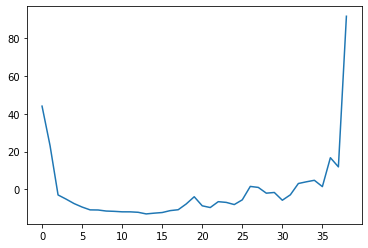

None


In [42]:
plt.plot(loss.scalars)
plt.show()

# what about stop signal?